In [1]:
pip install mne

Note: you may need to restart the kernel to use updated packages.


In [2]:
import keras
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split
from keras.layers import Input, Reshape, Activation, add, Add
from keras.layers import  BatchNormalization,Dense, Conv2D, Convolution2D, MaxPooling2D, Dropout, Flatten, TimeDistributed, InputLayer, LSTM
from keras.models import Sequential, Model 
from keras import optimizers

from keras import backend as K
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score 

%matplotlib inline

In [3]:
def recall(y_target, y_pred):
    y_target_yn = K.round(K.clip(y_target, 0, 1))
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    count_true_positive_false_negative = K.sum(y_target_yn)
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())
    return recall


def precision(y_target, y_pred):
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    y_target_yn = K.round(K.clip(y_target, 0, 1))
    count_true_positive = K.sum(y_target_yn * y_pred_yn)
    count_true_positive_false_positive = K.sum(y_pred_yn)
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    return _f1score

In [4]:
def reshapeLinearData(eeg):
    data=[]
    data=np.r_[eeg[0],eeg[1]]
    for i in range(2,len(eeg)):
        data=np.r_[data,eeg[i]]
    return data

In [5]:
def getData(src) :
    data = mne.io.read_raw_edf(src)
    raw_data = data.get_data()
    #info = data.info
    #channels = data.ch_names
    raw_data=raw_data[2:16]
    return raw_data#, info, channels

In [6]:
def drawGraph(hist, X_test, y_test) :
    fig, loss_ax = plt.subplots()

    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')

    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()
    return

def drawGraph2(hist, X_test, y_test) :
    fig, rec_ax = plt.subplots()

    pre_ax = rec_ax.twinx()

    rec_ax.plot(hist.history['recall'], 'y', label='train recall')
    rec_ax.plot(hist.history['val_recall'], 'r', label='val recall')

    pre_ax.plot(hist.history['precision'], 'b', label='train precision')
    pre_ax.plot(hist.history['val_precision'], 'g', label='val precision')

    rec_ax.set_xlabel('epoch')
    rec_ax.set_ylabel('recall')
    pre_ax.set_ylabel('precision')

    rec_ax.legend(loc='upper left')
    pre_ax.legend(loc='lower left')
    
    _loss, _acc, _precision, _recall, _f1score = model.evaluate(X_test, y_test)
    print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _precision, _recall, _f1score))

    plt.show()
    return

In [68]:
def filterData(df) :
    df=pd.DataFrame(df)
    for i in range(0,14) :
        idx=df[df[i] > 5].index
        df=df.drop(idx)
    return df

In [7]:
S01_1_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S01/1-Back/S01-01-25.09.2016.10.21.24.edf")
S01_2_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S01/2-Back/S01-01-25.09.2016.10.27.55.edf")
S01_Dual_1_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S01/Dual-1-Back/S01-01-25.09.2016.10.35.36.edf")
S01_Dual_2_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S01/Dual-2-Back/S01-01-25.09.2016.10.45.01.edf")
S01_Idle=getData("C:/Cognitive-Mental-workload-EEG-Data/S01/Idle/S01-01-25.09.2016.10.52.46.edf")

Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S01\1-Back\S01-01-25.09.2016.10.21.24.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S01\2-Back\S01-01-25.09.2016.10.27.55.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S01\Dual-1-Back\S01-01-25.09.2016.10.35.36.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S01\Dual-2-Back\S01-01-25.09.2016.10.45.01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S01\Idle\S01-01-25.09.2016.10.52.46.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [8]:
S02_1_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S02/1-Back/S02-01-25.09.2016.11.25.53.edf")
S02_2_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S02/2-Back/S02-01-25.09.2016.11.58.29.edf")
S02_Dual_1_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S02/Dual-1-Back/S02-01-25.09.2016.11.42.51.edf")
S02_Dual_2_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S02/Dual-2-Back/S02-01-25.09.2016.11.53.46.edf")
S02_Idle=getData("C:/Cognitive-Mental-workload-EEG-Data/S02/Idle/S02-01-25.09.2016.11.12.43.edf")

Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S02\1-Back\S02-01-25.09.2016.11.25.53.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S02\2-Back\S02-01-25.09.2016.11.58.29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S02\Dual-1-Back\S02-01-25.09.2016.11.42.51.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S02\Dual-2-Back\S02-01-25.09.2016.11.53.46.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S02\Idle\S02-01-25.09.2016.11.12.43.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [9]:
S03_1_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S03/1-Back/S03-01-25.09.2016.12.18.39.edf")
S03_2_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S03/2-Back/S03-01-25.09.2016.12.23.01.edf")
S03_Dual_1_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S03/Dual-1-Back/S03-01-25.09.2016.12.27.56.edf")
S03_Dual_2_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S03/Dual-2-Back/S03-01-25.09.2016.12.32.14.edf")
S03_Idle=getData("C:/Cognitive-Mental-workload-EEG-Data/S03/Idle/S03-01-25.09.2016.12.37.32.edf")

Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S03\1-Back\S03-01-25.09.2016.12.18.39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S03\2-Back\S03-01-25.09.2016.12.23.01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S03\Dual-1-Back\S03-01-25.09.2016.12.27.56.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S03\Dual-2-Back\S03-01-25.09.2016.12.32.14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S03\Idle\S03-01-25.09.2016.12.37.32.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [10]:
S04_1_Back_1=getData("C:/Cognitive-Mental-workload-EEG-Data/S04/1-Back/S04-01-27.09.2016.17.32.39.edf")
S04_1_Back_2=getData("C:/Cognitive-Mental-workload-EEG-Data/S04/1-Back/S04-01-27.09.2016.17.34.40.edf")
S04_2_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S04/2-Back/S04-01-27.09.2016.17.38.23.edf")
S04_Dual_1_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S04/Dual-1-Back/S04-01-27.09.2016.17.43.22.edf")
S04_Dual_2_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S04/Dual-2-Back/S04-01-27.09.2016.17.46.53.edf")
S04_Idle=getData("C:/Cognitive-Mental-workload-EEG-Data/S04/Idle/S04-01-27.09.2016.17.51.54.edf")

Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S04\1-Back\S04-01-27.09.2016.17.32.39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S04\1-Back\S04-01-27.09.2016.17.34.40.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S04\2-Back\S04-01-27.09.2016.17.38.23.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S04\Dual-1-Back\S04-01-27.09.2016.17.43.22.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S04\Dual-2-Back\S04-01-27.09.2016.17.46.53.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extra

In [11]:
S05_1_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S05/1-Back/S05-01-27.09.2016.18.08.39.edf")
S05_2_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S05/2-Back/S05-01-27.09.2016.18.12.18.edf")
S05_Dual_1_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S05/Dual-1-Back/S05-01-27.09.2016.18.16.18.edf")
S05_Dual_2_Back=getData("C:/Cognitive-Mental-workload-EEG-Data/S05/Dual-2-Back/S05-01-27.09.2016.18.20.17.edf")
S05_Idle=getData("C:/Cognitive-Mental-workload-EEG-Data/S05/Idle/S05-01-27.09.2016.18.24.46.edf")

Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S05\1-Back\S05-01-27.09.2016.18.08.39.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S05\2-Back\S05-01-27.09.2016.18.12.18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S05\Dual-1-Back\S05-01-27.09.2016.18.16.18.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S05\Dual-2-Back\S05-01-27.09.2016.18.20.17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Cognitive-Mental-workload-EEG-Data\S05\Idle\S05-01-27.09.2016.18.24.46.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [12]:
S01_1_Back=S01_1_Back.T
S01_2_Back=S01_2_Back.T
S01_Dual_1_Back=S01_Dual_1_Back.T
S01_Dual_2_Back=S01_Dual_2_Back.T
S01_Idle=S01_Idle.T

S02_1_Back=S02_1_Back.T
S02_2_Back=S02_2_Back.T
S02_Dual_1_Back=S02_Dual_1_Back.T
S02_Dual_2_Back=S02_Dual_2_Back.T
S02_Idle=S02_Idle.T

S03_1_Back=S03_1_Back.T
S03_2_Back=S03_2_Back.T
S03_Dual_1_Back=S03_Dual_1_Back.T
S03_Dual_2_Back=S03_Dual_2_Back.T
S03_Idle=S03_Idle.T

S04_1_Back_1=S04_1_Back_1.T
S04_1_Back_2=S04_1_Back_2.T
S04_2_Back=S04_2_Back.T
S04_Dual_1_Back=S04_Dual_1_Back.T
S04_Dual_2_Back=S04_Dual_2_Back.T
S04_Idle=S04_Idle.T

S05_1_Back=S05_1_Back.T
S05_2_Back=S05_2_Back.T
S05_Dual_1_Back=S05_Dual_1_Back.T
S05_Dual_2_Back=S05_Dual_2_Back.T
S05_Idle=S05_Idle.T

In [13]:
Back_1=np.r_[S01_1_Back,S02_1_Back]
Back_1=np.r_[Back_1,S03_1_Back]
Back_1=np.r_[Back_1,S04_1_Back_1]
Back_1=np.r_[Back_1,S04_1_Back_2]
Back_1=np.r_[Back_1,S05_1_Back]

In [14]:
Back_2=np.r_[S01_2_Back,S02_2_Back]
Back_2=np.r_[Back_2,S03_2_Back]
Back_2=np.r_[Back_2,S04_2_Back]
Back_2=np.r_[Back_2,S05_2_Back]

In [15]:
Dual_1_Back=np.r_[S01_Dual_1_Back,S02_Dual_1_Back]
Dual_1_Back=np.r_[Dual_1_Back,S03_Dual_1_Back]
Dual_1_Back=np.r_[Dual_1_Back,S04_Dual_1_Back]
Dual_1_Back=np.r_[Dual_1_Back,S05_Dual_1_Back]

In [16]:
Dual_2_Back=np.r_[S01_Dual_2_Back,S02_Dual_2_Back]
Dual_2_Back=np.r_[Dual_2_Back,S03_Dual_2_Back]
Dual_2_Back=np.r_[Dual_2_Back,S04_Dual_2_Back]
Dual_2_Back=np.r_[Dual_2_Back,S05_Dual_2_Back]

In [17]:
Idle=np.r_[S01_Idle,S02_Idle]
Idle=np.r_[Idle,S03_Idle]
Idle=np.r_[Idle,S04_Idle]
Idle=np.r_[Idle,S05_Idle]

In [18]:
print(Back_1.shape, Back_2.shape, Dual_1_Back.shape, Dual_2_Back.shape, Idle.shape)

(127232, 14) (114688, 14) (117376, 14) (111872, 14) (119040, 14)


In [19]:
Back_1=Back_1*1000
Back_2=Back_2*1000
Dual_1_Back=Dual_1_Back*1000
Dual_2_Back=Dual_2_Back*1000
Idle=Idle*1000

In [20]:
Back1=pd.DataFrame(Back_1)
Back2=pd.DataFrame(Back_2)
Dual1=pd.DataFrame(Dual_1_Back)
Dual2=pd.DataFrame(Dual_2_Back)
Idle=pd.DataFrame(Idle)

In [70]:
test=pd.DataFrame(Back_1)
test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,4.175897,4.173846,4.170256,4.170256,4.179487,4.175897,4.174872,4.177949,4.181026,4.161026,4.176923,4.190256,4.173846,4.146667
1,4.175385,4.175897,4.163590,4.171282,4.188205,4.177949,4.177436,4.175385,4.178462,4.170769,4.178462,4.191282,4.181026,4.144103
2,4.178974,4.172308,4.170769,4.168205,4.170769,4.196410,4.184615,4.173333,4.177436,4.169744,4.175385,4.196923,4.170769,4.145128
3,4.193333,4.194872,4.176410,4.188205,4.184615,4.206154,4.188718,4.187692,4.200000,4.179487,4.195385,4.216410,4.187179,4.167179
4,4.160000,4.160513,4.150769,4.156410,4.183590,4.155385,4.143590,4.144615,4.173846,4.154359,4.165641,4.184103,4.162051,4.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127227,4.205128,4.206154,4.211282,4.203077,4.225641,4.230769,4.231282,4.195897,4.211282,4.219487,4.228205,4.201538,4.216923,4.199487
127228,4.222051,4.217436,4.231282,4.220513,4.234872,4.231282,4.254359,4.206154,4.222564,4.242051,4.243077,4.216410,4.232308,4.212308
127229,4.215385,4.206667,4.225641,4.210769,4.238462,4.234359,4.252308,4.195897,4.216410,4.233846,4.234359,4.212821,4.220000,4.206667
127230,4.229744,4.217949,4.238974,4.229231,4.258974,4.247692,4.250769,4.204615,4.229231,4.230769,4.248205,4.226667,4.230769,4.220000


In [72]:
Back_1=filterData(Back_1)
Back1=filterData(Back_1)
Back2=filterData(Back_2)
Dual1=filterData(Dual_1_Back)
Dual2=filterData(Dual_2_Back)
Idle=filterData(Idle)

In [73]:
#결측값 제거 (0값 제거)
Back1_idx = Back1[:].isin(['0'])
Back2_idx=Back2[:].isin(['0'])
Dual1_idx=Dual1[:].isin(['0'])
Dual2_idx=Dual2[:].isin(['0'])
Idle_idx=Idle[:].isin(['0'])

Back1=Back1[~Back1_idx]
Back2=Back2[~Back2_idx]
Dual1=Dual1[~Dual1_idx]
Dual2=Dual2[~Dual2_idx]
Idle=Idle[~Idle_idx]

Back1.dropna(inplace=True)
Back2.dropna(inplace=True)
Dual1.dropna(inplace=True)
Dual2.dropna(inplace=True)
Idle.dropna(inplace=True)

Back1=Back1.values
Back2=Back2.values
Dual1=Dual1.values
Dual2=Dual2.values
Idle=Idle.values

In [74]:
scaler=MinMaxScaler()
Back_1[:]=scaler.fit_transform(Back_1[:])*255
Back_2[:]=scaler.fit_transform(Back_2[:])*255
Dual_1_Back[:]=scaler.fit_transform(Dual_1_Back[:])*255
Dual_2_Back[:]=scaler.fit_transform(Dual_2_Back[:])*255
Idle[:]=scaler.fit_transform(Idle[:])*255

In [75]:
print(Back1.shape, Back2.shape, Dual1.shape, Dual2.shape, Idle.shape)

(127170, 14) (114635, 14) (117376, 14) (111871, 14) (118739, 14)


In [76]:
data=np.r_[Back1, Back2]
data=np.r_[data, Dual1]
data=np.r_[data, Dual2]
data=np.r_[data, Idle]
print(data.shape)

(589791, 14)


In [77]:
label_0=np.zeros((len(Back1),1))
label_1=np.ones((len(Back2),1))
label_2=np.full((len(Dual1),1),2)
label_3=np.full((len(Dual2),1),3)
label_4=np.full((len(Idle),1),4)
print(label_0.shape, label_1.shape, label_2.shape, label_3.shape, label_4.shape)

(127170, 1) (114635, 1) (117376, 1) (111871, 1) (118739, 1)


In [78]:
label=np.r_[label_0, label_1]
label=np.r_[label, label_2]
label=np.r_[label, label_3]
label=np.r_[label, label_4]
print(label.shape)

(589791, 1)


In [79]:
label=to_categorical(label,5)
print(data.shape, label.shape)

(589791, 14) (589791, 5)


In [80]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=None, shuffle=True, stratify=label)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(412853, 14) (176938, 14) (412853, 5) (176938, 5)


In [81]:
def model_create(eeg_data):
    eeg_input=Input(shape=(14,)) #입력 정의
    
    eeg_output = Dense(50, activation='relu')(eeg_input)
    eeg_output = Dropout(0.5)(eeg_output)
    eeg_output = Dense(150, activation='relu')(eeg_input)
    eeg_output = Dropout(0.5)(eeg_output)
    eeg_output = Dense(150, activation='relu')(eeg_input)
    eeg_output = Dropout(0.5)(eeg_output)
    eeg_output = Dense(200, activation='relu')(eeg_output)
    
    model = Dense(5, activation='sigmoid')(eeg_output)
    
    model = keras.models.Model(inputs=eeg_input, outputs=model) 
    
    model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy', precision, recall, f1score])
    
    return model 

model=model_create(data)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               2250      
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               30200     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1005      
Total params: 33,455
Trainable params: 33,455
Non-trainable params: 0
_________________________________________________________________


In [82]:
hist=model.fit(X_train, y_train, epochs=30, batch_size=10, validation_data=(X_test,y_test))

Epoch 1/30
41286/41286 [==============================] - 28s 673us/step - loss: 0.3617 - accuracy: 0.4098 - precision: 0.8916 - recall: 0.2012 - f1score: 0.3164 - val_loss: 0.3593 - val_accuracy: 0.4169 - val_precision: 0.8963 - val_recall: 0.2013 - val_f1score: 0.3172
Epoch 2/30
41286/41286 [==============================] - 28s 682us/step - loss: 0.3599 - accuracy: 0.4137 - precision: 0.8929 - recall: 0.2010 - f1score: 0.3165 - val_loss: 0.3591 - val_accuracy: 0.4169 - val_precision: 0.8963 - val_recall: 0.2013 - val_f1score: 0.3172
Epoch 3/30
41286/41286 [==============================] - 28s 681us/step - loss: 0.3595 - accuracy: 0.4156 - precision: 0.8942 - recall: 0.2012 - f1score: 0.3166 - val_loss: 0.3604 - val_accuracy: 0.4158 - val_precision: 0.8963 - val_recall: 0.2013 - val_f1score: 0.3172
Epoch 4/30
41286/41286 [==============================] - 28s 676us/step - loss: 0.3592 - accuracy: 0.4159 - precision: 0.8939 - recall: 0.2013 - f1score: 0.3168 - val_loss: 0.3592 - val_

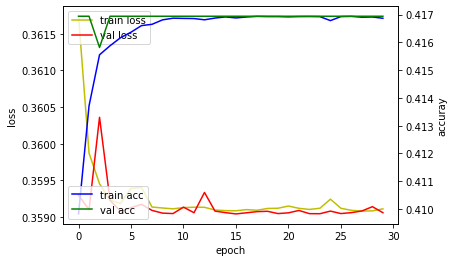

In [83]:
drawGraph(hist, X_test, y_test)

5530/5530 [==============================] - 2s 360us/step - loss: 0.3591 - accuracy: 0.4169 - precision: 0.9986 - recall: 0.2013 - f1score: 0.3296
loss: 0.359, accuracy: 0.417, precision: 0.999, recall: 0.201, f1score: 0.330


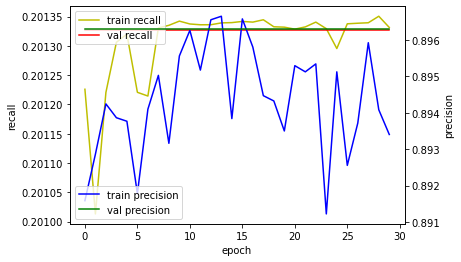

In [84]:
drawGraph2(hist, X_test, y_test)

In [85]:
X_train = X_train.reshape(X_train.shape+ (1,))
X_test = X_test.reshape(X_test.shape + (1,))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

def lstm_model():
    model = Sequential()
    model.add(LSTM(50, input_shape = (14,1), return_sequences = True))
    model.add(LSTM(5, return_sequences = False))
    model.add(Activation('sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy', precision, recall, f1score])
    return model

model = lstm_model()

model.summary()

(412853, 14, 1) (176938, 14, 1) (412853, 5) (176938, 5)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5)                 1120      
_________________________________________________________________
activation (Activation)      (None, 5)                 0         
Total params: 11,520
Trainable params: 11,520
Non-trainable params: 0
_________________________________________________________________


In [86]:
hist=model.fit(X_train, y_train, epochs=30, batch_size=8, validation_data=(X_test,y_test))

Epoch 1/30
51607/51607 [==============================] - 236s 5ms/step - loss: 0.4761 - accuracy: 0.3993 - precision: 0.7573 - recall: 0.1829 - f1score: 0.2840 - val_loss: 0.4883 - val_accuracy: 0.2671 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 2/30
51607/51607 [==============================] - 234s 5ms/step - loss: 0.4884 - accuracy: 0.4121 - precision: 2.9066e-05 - recall: 4.8443e-06 - f1score: 8.1815e-06 - val_loss: 0.4883 - val_accuracy: 0.4169 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 3/30
51607/51607 [==============================] - 230s 4ms/step - loss: 0.4884 - accuracy: 0.4169 - precision: 3.8754e-05 - recall: 4.8443e-06 - f1score: 8.6121e-06 - val_loss: 0.4883 - val_accuracy: 0.4169 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00
Epoch 4/30
51607/51607 [==============================] - 233s 5ms/step - loss: 0.4884 - accuracy: 0.4169 - precision: 3.8754e-05 

Epoch 30/30
51607/51607 [==============================] - 240s 5ms/step - loss: 0.5135 - accuracy: 0.2156 - precision: 3.8754e-05 - recall: 4.8443e-06 - f1score: 8.6121e-06 - val_loss: 0.5133 - val_accuracy: 0.2156 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1score: 0.0000e+00


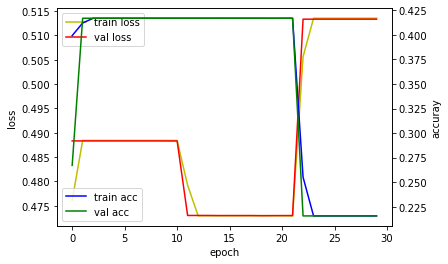

In [87]:
drawGraph(hist, X_test, y_test)

5530/5530 [==============================] - 7s 1ms/step - loss: 0.5133 - accuracy: 0.2156 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1score: 0.0000e+00
loss: 0.513, accuracy: 0.216, precision: 0.000, recall: 0.000, f1score: 0.000


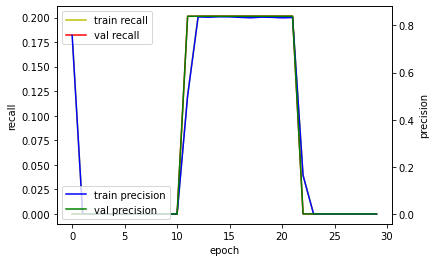

In [88]:
drawGraph2(hist, X_test, y_test)

In [89]:
print(Back1.shape, Back2.shape, Dual1.shape, Dual2.shape, Idle.shape)

(127170, 14) (114635, 14) (117376, 14) (111871, 14) (118739, 14)


In [98]:
import random

index1=[]
for i in range(len(Back1)%14) :
    index1.append(random.randint(0,len(Back1)-1))

index2=[]
for i in range(len(Back2)%14) :
    index2.append(random.randint(0,len(Back2)-1))

index3=[]
for i in range(len(Dual1)%14) :
    index3.append(random.randint(0,len(Dual1)-1))

index4=[]
for i in range(len(Dual2)%14) :
    index4.append(random.randint(0,len(Dual2)-1))

index5=[]
for i in range(len(Idle)%14) :
    index5.append(random.randint(0,len(Idle)-1))

Back1_c=pd.DataFrame(Back1)   
Back2_c=pd.DataFrame(Back2)
Dual1_c=pd.DataFrame(Dual1)
Dual2_c=pd.DataFrame(Dual2)
Idle_c=pd.DataFrame(Idle)

Back1_c=Back1_c.drop(index1)
Back2_c=Back2_c.drop(index2)
Dual1_c=Dual1_c.drop(index3)
Dual2_c=Dual2_c.drop(index4)
Idle_c=Idle_c.drop(index5)

Back1_c=Back1_c.values
Back2_c=Back2_c.values
Dual1_c=Dual1_c.values
Dual2_c=Dual2_c.values
Idle_c=Idle_c.values

In [99]:
Back1_c=Back1_c.reshape(-1,14,14)
Back2_c=Back2_c.reshape(-1,14,14)
Dual1_c=Dual1_c.reshape(-1,14,14)
Dual2_c=Dual2_c.reshape(-1,14,14)
Idle_c=Idle_c.reshape(-1,14,14)

In [100]:
print(Back1_c.shape, Back2_c.shape, Dual1_c.shape, Dual2_c.shape, Idle_c.shape)

(9083, 14, 14) (8188, 14, 14) (8384, 14, 14) (7990, 14, 14) (8481, 14, 14)


In [101]:
eeg=np.r_[Back1_c, Back2_c]
eeg=np.r_[eeg, Dual1_c]
eeg=np.r_[eeg, Dual2_c]
eeg=np.r_[eeg, Idle_c]
print(eeg.shape)

(42126, 14, 14)


In [102]:
label_0=np.zeros((len(Back1_c),1))
label_1=np.ones((len(Back2_c),1))
label_2=np.full((len(Dual1_c),1),2)
label_3=np.full((len(Dual2_c),1),3)
label_4=np.full((len(Idle_c),1),4)
print(label_0.shape, label_1.shape, label_2.shape, label_3.shape, label_4.shape)

(9083, 1) (8188, 1) (8384, 1) (7990, 1) (8481, 1)


In [103]:
label=np.r_[label_0, label_1]
label=np.r_[label, label_2]
label=np.r_[label, label_3]
label=np.r_[label, label_4]
print(label.shape)

(42126, 1)


In [104]:
label=to_categorical(label,5)
print(eeg.shape, label.shape)

(42126, 14, 14) (42126, 5)


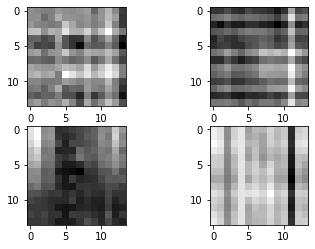

In [106]:
plt.subplot(221)
plt.imshow(eeg[0], cmap='gray')

plt.subplot(222)
plt.imshow(eeg[19000], cmap='gray')

plt.subplot(223)
plt.imshow(eeg[29000], cmap='gray')

plt.subplot(224)
plt.imshow(eeg[42000], cmap='gray')

In [107]:
X_train, X_test, y_train, y_test = train_test_split(eeg, label, test_size=0.3, random_state=None, shuffle=True, stratify=label)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(29488, 14, 14) (12638, 14, 14) (29488, 5) (12638, 5)


In [108]:
X_train = X_train.reshape(X_train.shape+ (1,))
X_test = X_test.reshape(X_test.shape + (1,))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(29488, 14, 14, 1) (12638, 14, 14, 1) (29488, 5) (12638, 5)


In [109]:
def basic_cnn():
    model = Sequential()

    model.add(Conv2D(input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), filters = 50, kernel_size = (2,2), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters = 50, kernel_size = (2,2), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    model.add(Conv2D(filters = 50, kernel_size = (2,2), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(filters = 50, kernel_size = (2,2), strides = (1,1), padding = 'same'))
    model.add(Activation('relu'))

    # prior layer should be flattend to be connected to dense layers
    model.add(Flatten())
    
    
    # final layer with 10 neurons to classify the instances
    model.add(Dense(50, activation = 'relu'))
    
    # final layer with 10 neurons to classify the instances
    model.add(Dense(5, activation = 'softmax'))

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics=['accuracy', precision, recall, f1score])
    return model

model = basic_cnn()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 50)        250       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        10050     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 50)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 50)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 50)          10050     
_________________________________________________________________
activation_3 (Activation)    (None, 7, 7, 50)         

In [ ]:
hist=model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test,y_test))

Epoch 1/20
3686/3686 [==============================] - 13s 4ms/step - loss: 0.3682 - accuracy: 0.4033 - precision: 0.8269 - recall: 0.2002 - f1score: 0.3107 - val_loss: 0.3595 - val_accuracy: 0.4169 - val_precision: 0.8487 - val_recall: 0.2013 - val_f1score: 0.3141
Epoch 2/20
1599/3686 [============>.................] - ETA: 5s - loss: 0.3608 - accuracy: 0.4119 - precision: 0.8311 - recall: 0.1983 - f1score: 0.3087

In [ ]:
drawGraph(hist, X_test, y_test)

In [ ]:
drawGraph2(hist, X_test, y_test)